### Notebook based on:
https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

# Imports

In [1]:
########################## EDA
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

# Read data

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/movie-reviews/IMDB Dataset.csv.zip

In [3]:
df = pd.read_csv("../data/movie-reviews/IMDB Dataset.csv.zip")
df.head(2)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


In [4]:
df_train = df[:25000]
df_valid = df[25000:]

print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 25000
Number of documents in validation data: 25000


# EDA
### Target

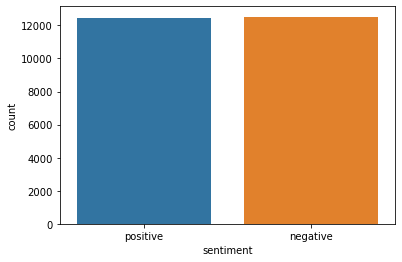

In [5]:
sb.countplot(df_train['sentiment']);

### Text

In [6]:
positive = df[df['sentiment']=="positive"]['review']
negative = df[df['sentiment']=="negative"]['review']

CPU times: user 28.7 s, sys: 1.13 s, total: 29.8 s
Wall time: 29.8 s


Text(0.5, 1.0, 'Negative')

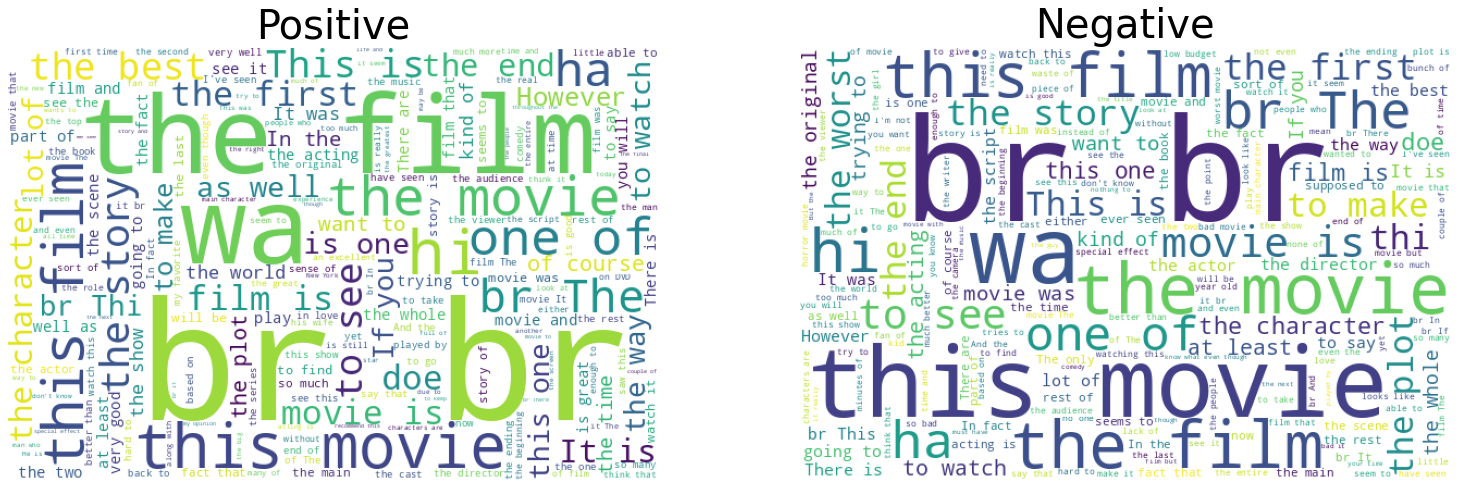

In [9]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [7]:
texts = [
    'Hola esto es una frase',
    'Hola esto es otra frase',
    'Hola hola hola, no vengas sola'
]

### Bag Of Words (BOW)

In [8]:
bow = CountVectorizer()
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,esto,frase,hola,no,otra,sola,una,vengas
Text 1,1,1,1,1,0,0,0,1,0
Text 2,1,1,1,1,0,1,0,0,0
Text 3,0,0,0,3,1,0,1,0,1


### Bag Of Words (BOW) + ngram

In [9]:
bow = CountVectorizer(ngram_range=(1, 2))
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,es otra,es una,esto,esto es,frase,hola,hola esto,hola hola,hola no,no,no vengas,otra,otra frase,sola,una,una frase,vengas,vengas sola
Text 1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0
Text 2,1,1,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0
Text 3,0,0,0,0,0,0,3,0,2,1,1,1,0,0,1,0,0,1,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [10]:
tfidf = TfidfVectorizer()
texts_tfidf = tfidf.fit_transform(texts)
tokens = tfidf.get_feature_names()
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,es,esto,frase,hola,no,otra,sola,una,vengas
Text 1,0.433067,0.433067,0.433067,0.336315,0.000000,0.000000,0.000000,0.569431,0.000000
Text 2,0.433067,0.433067,0.433067,0.336315,0.000000,0.569431,0.000000,0.000000,0.000000
Text 3,0.000000,0.000000,0.000000,0.715092,0.403585,0.000000,0.403585,0.000000,0.403585


# <center> Aplicar a las reviews

### Bag Of Words 1-gram

In [11]:
%%time
bow_1gram = CountVectorizer()
train_bow_1gram = bow_1gram.fit_transform(df_train['review'])
valid_bow_1gram = bow_1gram.transform(df_valid['review'])

CPU times: user 5.22 s, sys: 27.5 ms, total: 5.25 s
Wall time: 5.25 s


### Bag Of Words 1-2-grams

In [12]:
%%time
bow_2grams = CountVectorizer(ngram_range=(1, 2))
train_bow_2grams = bow_2grams.fit_transform(df_train['review'])
valid_bow_2grams = bow_2grams.transform(df_valid['review'])

CPU times: user 16.9 s, sys: 269 ms, total: 17.2 s
Wall time: 17.2 s


### TFIDF 1-gram

In [13]:
%%time
tfidf_1gram       = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1))
train_tfidf_1gram = tfidf_1gram.fit_transform(df_train['review'])
valid_tfidf_1gram = tfidf_1gram.transform(df_valid['review'])

CPU times: user 5.54 s, sys: 9.89 ms, total: 5.55 s
Wall time: 5.55 s


### TFIDF 1-2-grams

In [14]:
%%time
tfidf_2grams      = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf_2grams = tfidf_2grams.fit_transform(df_train['review'])
valid_tfidf_2grams = tfidf_2grams.transform(df_valid['review'])

CPU times: user 15.3 s, sys: 213 ms, total: 15.5 s
Wall time: 15.5 s


In [16]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (25000, 76496)
BOW 2grams   (25000, 1513369)
TFIDF 1gram  (25000, 45185)
TFIDF 2grams (25000, 433699)


# <center> ML Models

In [22]:
y_train = df_train["sentiment"].replace({"negative": 0, "positive": 1})
y_valid = df_valid["sentiment"].replace({"negative": 0, "positive": 1})

## Naive Bayes (<1 segundo)

In [24]:
for name, x_train, x_valid in data:
    
    model = MultinomialNB()
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_valid, model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.84428 	Time:	 0.018774747848510742
BOW 2grams 	Accuracy:	 0.878 	Time:	 0.13236117362976074
TFIDF 1gram 	Accuracy:	 0.8604 	Time:	 0.014917850494384766
TFIDF 2grams 	Accuracy:	 0.88544 	Time:	 0.05532026290893555


## Logistic Regression (30 segundos)

In [25]:
for name, x_train, x_valid in data:
    
    model = LogisticRegression(n_jobs=-1)
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_valid, model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8856 	Time:	 2.3662497997283936
BOW 2grams 	Accuracy:	 0.90076 	Time:	 23.640942335128784
TFIDF 1gram 	Accuracy:	 0.89168 	Time:	 1.5041086673736572
TFIDF 2grams 	Accuracy:	 0.89688 	Time:	 3.6333465576171875


## Random Forest (10+90+6+22 segundos)

In [26]:
for name, x_train, x_valid in data:
    
    model = RandomForestClassifier(n_jobs=-1)
    ts = time.time()
    model.fit(x_train, y_train)
    t = time.time() - ts
    a = accuracy_score(y_valid, model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8482 	Time:	 13.228048086166382
BOW 2grams 	Accuracy:	 0.85832 	Time:	 93.41943311691284
TFIDF 1gram 	Accuracy:	 0.8454 	Time:	 9.45107913017273
TFIDF 2grams 	Accuracy:	 0.8552 	Time:	 27.58473038673401
